# Continuous Control with Deep Deterministic Policy Gradient (DDPG)

### Install dependencies

In [7]:
# Install python packages

# !pip install mlagents==0.4.0
# !pip install pytorch=0.4.0

In [9]:
# Install Reacher environment

# !wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux_NoVis.zip
# !unzip Reacher_Linux_NoVis.zip
# !rm Reacher_Linux_NoVis.zip

In [3]:
from collections import deque, namedtuple
import random
import copy

from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt

from ddpg import DDPGAgent as Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Examine the environment

In [4]:
if 'env' not in locals():
    env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

for name in env.brain_names:
    print("Brain found: ", name)

# set the first and only brain as active
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
print(states.shape)
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for all the agents is shape of', states.shape)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Brain found:  ReacherBrain
Number of agents: 20
Size of each action: 4
(20, 33)
There are 20 agents. Each observes a state with length: 33
The state for all the agents is shape of (20, 33)


### Train the agent

In [5]:
def train(
        env,
        agent,
        n_episodes=10,
        max_time_steps=300,
        target_score=30.):
    """Training loop for a given agent in a given environment.

    Args:
        agent: instance of class Agent
        env: Unity environment
        n_episodes (int): maximum number of training episodes
        max_time_steps (int): maximum number of timesteps per episode
        target_score (float): target score at which to end training

    Side effects:
        Alters the state of `agent` and `env`.

    Returns:
        list: sum of all rewards per episode
    """
    scores = []
    scores_window = deque(maxlen=100)

    brain_name = env.brain_names[0]
    
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)

    for i_episode in range(1, n_episodes + 1):

        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations

        score = 0
        
        agent.reset()
        for t in range(max_time_steps):

            # choose and execute an action
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]

            # observe state and reward
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            ended = env_info.local_done

            # save action, obervation and reward for learning
            agent.step(states, actions, rewards, next_states, ended)
            states = next_states

            score += np.mean(rewards)

            if np.any(ended):
                print("Episode ended before limit {max_time_steps}")
                break

        scores.append(score)
        scores_window.append(score)

        max_score = np.max(scores)

        print(f"\rEpisode {i_episode}\tAvg score: {score:.2f}\tMax score: {max_score:.2f}")

        if np.mean(scores_window) >= target_score:
            print(f"\nTarget score reached in {i_episode-100:d} episodes!")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores

Episode 1	Avg score: 0.35	Max score: 0.35
Episode 2	Avg score: 1.00	Max score: 1.00
Episode 3	Avg score: 1.15	Max score: 1.15
Episode 4	Avg score: 0.77	Max score: 1.15
Episode 5	Avg score: 0.87	Max score: 1.15
Episode 6	Avg score: 0.96	Max score: 1.15
Episode 7	Avg score: 1.21	Max score: 1.21
Episode 8	Avg score: 1.36	Max score: 1.36
Episode 9	Avg score: 1.23	Max score: 1.36
Episode 10	Avg score: 1.29	Max score: 1.36
Episode 11	Avg score: 1.46	Max score: 1.46
Episode 12	Avg score: 1.27	Max score: 1.46
Episode 13	Avg score: 0.96	Max score: 1.46
Episode 14	Avg score: 1.57	Max score: 1.57
Episode 15	Avg score: 1.71	Max score: 1.71
Episode 16	Avg score: 1.97	Max score: 1.97
Episode 17	Avg score: 2.11	Max score: 2.11
Episode 18	Avg score: 2.55	Max score: 2.55
Episode 19	Avg score: 2.15	Max score: 2.55
Episode 20	Avg score: 2.52	Max score: 2.55
Episode 21	Avg score: 3.01	Max score: 3.01
Episode 22	Avg score: 3.36	Max score: 3.36
Episode 23	Avg score: 3.57	Max score: 3.57
Episode 24	Avg score

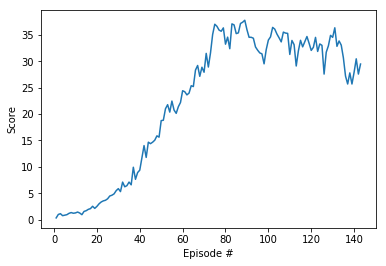

In [6]:
ddpg_agent = Agent(state_size, action_size)
scores = train(env, ddpg_agent, n_episodes=300, max_time_steps=1000, target_score=30.)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('scores.png')
plt.show()

# env.close()